In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
from geopandas import GeoSeries
import seaborn as sns
from itertools import chain
import json
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
%matplotlib inline
import matplotlib.font_manager as fm
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape 
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from fiona.crs import from_epsg
import pysal as ps
from pysal.contrib.viz import mapping as maps
from tqdm import tqdm
from geopandas.tools import sjoin

/usr/local/lib/python2.7/dist-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)
/usr/local/lib/python2.7/dist-packages/pysal/contrib/viz/mapping.py:32: UserWarning: Bokeh not installed. Functionality related to it will not work
  warn('Bokeh not installed. Functionality '


In [2]:
space_syntax_uk = gpd.read_file('../Data/SpaceSyntax/OpenMapping-gb-v1_shp/shp/ssx_openmapping_gb_v1.shp')

In [17]:
space_syntax_uk.head()

,ID,METRES,MER_ID,MER_GID,CODE,OSODR,NUMBER,ROAD_NAME,INDICATOR,CLASS,...,OA11CD,WZ11CD,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,SCALE,geometry
0,562327,254.310833,1088452,61975,3002,O168XXWEMU8AW,B3395,SANDOWN ROAD,,broad,...,E00087303,E33041113,E01017285,Isle of Wight 010B,E02003590,Isle of Wight 010,E06000046,Isle of Wight,2,"LINESTRING (461136.000 86168.000, 461379.000 8..."
1,562328,105.702412,1088454,776232,3004,O168YDCENPWTW,,VICTORIA ROAD,,minor,...,E00087614,E33041136,E01017348,Isle of Wight 014C,E02003594,Isle of Wight 014,E06000046,Isle of Wight,1,"LINESTRING (460000.000 84460.000, 460097.000 8..."
2,562329,89.050547,1088455,776234,3004,O168YBRXNN7TW,,CARTER STREET,,minor,...,E00087615,E33041136,E01017348,Isle of Wight 014C,E02003594,Isle of Wight 014,E06000046,Isle of Wight,1,"LINESTRING (460000.000 84591.000, 460089.000 8..."
3,562330,110.476242,1088456,776235,3004,O168YC3ENL9AW,,CROSS STREET,,minor,...,E00087615,E33041136,E01017348,Isle of Wight 014C,E02003594,Isle of Wight 014,E06000046,Isle of Wight,1,"LINESTRING (460000.000 84766.000, 460051.000 8..."
4,563907,108.171161,1089614,776809,3004,O168WXEXKKFAW,,SOLENT VIEW ROAD,,minor,...,E00087631,E33041112,E01017352,Isle of Wight 010E,E02003590,Isle of Wight 010,E06000046,Isle of Wight,1,"LINESTRING (462894.000 90926.000, 462999.000 9..."


In [18]:
london_wards = gpd.read_file('../Data/SpaceSyntax/London-wards-2014/London-wards-2014_ESRI/London_Ward.shp')

In [21]:
london_wards.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((517829.600 165447.100, 517837.100 16..."
2,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((518107.500 167303.400, 518114.300 16..."
3,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((520480.000 166909.800, 520490.700 16..."
4,Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((522071.000 168144.900, 522063.900 16..."


In [79]:
len(london_wards)

654

In [48]:
london_lsoa = pd.read_csv('../Data/SpaceSyntax/London-wards-2014/ons-mye-lsoa11.csv')

In [49]:
london_lsoa.head()
london_lsoa = london_lsoa[london_lsoa['Year'] == 2011].copy()

In [50]:
london_lsoa = london_lsoa[['Lower Super Output Area','LAD11CD','LAD11NM']]

In [51]:
lsoa_ward_lookup = pd.read_csv('../Data/SpaceSyntax/OpenMapping-gb-v1_shp/shp/lower_layer_super_output_area_2011_to_ward_2015_lookup_in_england_and_wales.csv')

In [52]:
london_lsoa_ward_lookup = pd.merge(lsoa_ward_lookup,london_lsoa , left_on='LSOA11CD' , right_on='Lower Super Output Area', how='inner')

In [53]:
london_lsoa_ward_lookup.head()

,LSOA11CD,LSOA11NM,WD15CD,WD15NM,WD15NMW,LAD15CD,LAD15NM,FID,Lower Super Output Area,LAD11CD,LAD11NM
0,E01000104,Barking and Dagenham 014B,E05000041,Village,,E09000002,Barking and Dagenham,1,E01000104,E09000002,Barking and Dagenham
1,E01000105,Barking and Dagenham 014C,E05000041,Village,,E09000002,Barking and Dagenham,2,E01000105,E09000002,Barking and Dagenham
2,E01000106,Barking and Dagenham 014D,E05000041,Village,,E09000002,Barking and Dagenham,3,E01000106,E09000002,Barking and Dagenham
3,E01000107,Barking and Dagenham 010C,E05000041,Village,,E09000002,Barking and Dagenham,4,E01000107,E09000002,Barking and Dagenham
4,E01000108,Barking and Dagenham 010D,E05000041,Village,,E09000002,Barking and Dagenham,5,E01000108,E09000002,Barking and Dagenham


In [54]:
len(london_lsoa_ward_lookup)

4835

In [55]:
syntax_lsoa_merge = pd.merge(space_syntax_uk,london_lsoa_ward_lookup,left_on='LSOA11CD',right_on='Lower Super Output Area')

In [56]:
len(syntax_lsoa_merge)

114582

In [57]:
syntax_lsoa_merge

,ID,METRES,MER_ID,MER_GID,CODE,OSODR,NUMBER,ROAD_NAME,INDICATOR,CLASS,...,LSOA11NM_y,WD15CD,WD15NM,WD15NMW,LAD15CD,LAD15NM,FID,Lower Super Output Area,LAD11CD_y,LAD11NM_y
0,562736,73.389373,1088986,959901,3004,O167UFWW0X5TW,,AMBERLEY ROAD,,minor,...,Enfield 021B,E05000194,Bush Hill Park,,E09000010,Enfield,1454,E01001399,E09000010,Enfield
1,562790,226.384628,1088804,124068,3001,O167UJWD14LAW,A10,GREAT CAMBRIDGE ROAD,,aroad,...,Enfield 021B,E05000194,Bush Hill Park,,E09000010,Enfield,1454,E01001399,E09000010,Enfield
2,562792,8.602325,1088806,124161,3001,O167UD8W0YATW,A10,GREAT CAMBRIDGE ROAD,,aroad,...,Enfield 021B,E05000194,Bush Hill Park,,E09000010,Enfield,1454,E01001399,E09000010,Enfield
3,562793,8.062258,1088807,124162,3001,O167UDAW0YEAW,A10,GREAT CAMBRIDGE ROAD,,aroad,...,Enfield 021B,E05000194,Bush Hill Park,,E09000010,Enfield,1454,E01001399,E09000010,Enfield
4,562801,48.826222,1088815,124462,3001,O167UD0D0XYAW,A10,GREAT CAMBRIDGE ROAD,,aroad,...,Enfield 021B,E05000194,Bush Hill Park,,E09000010,Enfield,1454,E01001399,E09000010,Enfield
5,562802,23.600847,1088815,124462,3001,O167UD0D0XYAW,A10,GREAT CAMBRIDGE ROAD,,aroad,...,Enfield 021B,E05000194,Bush Hill Park,,E09000010,Enfield,1454,E01001399,E09000010,Enfield
6,562803,95.801879,1088816,124471,3001,O167UDND0YXAW,A10,GREAT CAMBRIDGE ROAD,,aroad,...,Enfield 021B,E05000194,Bush Hill Park,,E09000010,Enfield,1454,E01001399,E09000010,Enfield
7,562804,35.805028,1088816,124471,3001,O167UDND0YXAW,A10,GREAT CAMBRIDGE ROAD,,aroad,...,Enfield 021B,E05000194,Bush Hill Park,,E09000010,Enfield,1454,E01001399,E09000010,Enfield
8,562846,212.532350,1088848,957875,3004,O167ULLW0Y7AW,,BURY STREET WEST,,minor,...,Enfield 021B,E05000194,Bush Hill Park,,E09000010,Enfield,1454,E01001399,E09000010,Enfield
9,562866,132.003788,1088866,958065,3004,O167UK8D0W8AW,,ASH GROVE,,minor,...,Enfield 021B,E05000194,Bush Hill Park,,E09000010,Enfield,1454,E01001399,E09000010,Enfield


In [61]:
syntax_lsoa_merge.columns

Index([                     u'ID',                  u'METRES',
                        u'MER_ID',                 u'MER_GID',
                          u'CODE',                   u'OSODR',
                        u'NUMBER',               u'ROAD_NAME',
                     u'INDICATOR',                   u'CLASS',
                          u'CH2K',                u'CH2KRANK',
                       u'CH2KLOG',                    u'NC2K',
                         u'INT2K',               u'INT2KRANK',
                         u'CH10K',               u'CH10KRANK',
                      u'CH10KLOG',                   u'NC10K',
                        u'INT10K',              u'INT10KRANK',
                        u'CH100K',               u'CH100KLOG',
                        u'NC100K',                 u'INT100K',
                        u'OA11CD',                  u'WZ11CD',
                    u'LSOA11CD_x',              u'LSOA11NM_x',
                      u'MSOA11CD',                u'MSO

In [64]:
syntax_values = syntax_lsoa_merge[['WD15CD','LSOA11CD_x','LAD15CD','LAD15NM','CH2K','INT2K','geometry']].copy()

In [65]:
syntax_values.head()

,WD15CD,LSOA11CD_x,LAD15CD,LAD15NM,CH2K,INT2K,geometry
0,E05000194,E01001399,E09000010,Enfield,8486.0,142.716374,"LINESTRING (533496.000 194642.000, 533521.000 ..."
1,E05000194,E01001399,E09000010,Enfield,11131.0,185.716093,"LINESTRING (533429.000 194331.000, 533594.000 ..."
2,E05000194,E01001399,E09000010,Enfield,11688.0,185.588268,"LINESTRING (533676.000 194599.000, 533681.000 ..."
3,E05000194,E01001399,E09000010,Enfield,15329.0,187.078741,"LINESTRING (533672.000 194592.000, 533676.000 ..."
4,E05000194,E01001399,E09000010,Enfield,11003.0,179.861718,"LINESTRING (533723.000 194665.000, 533695.000 ..."


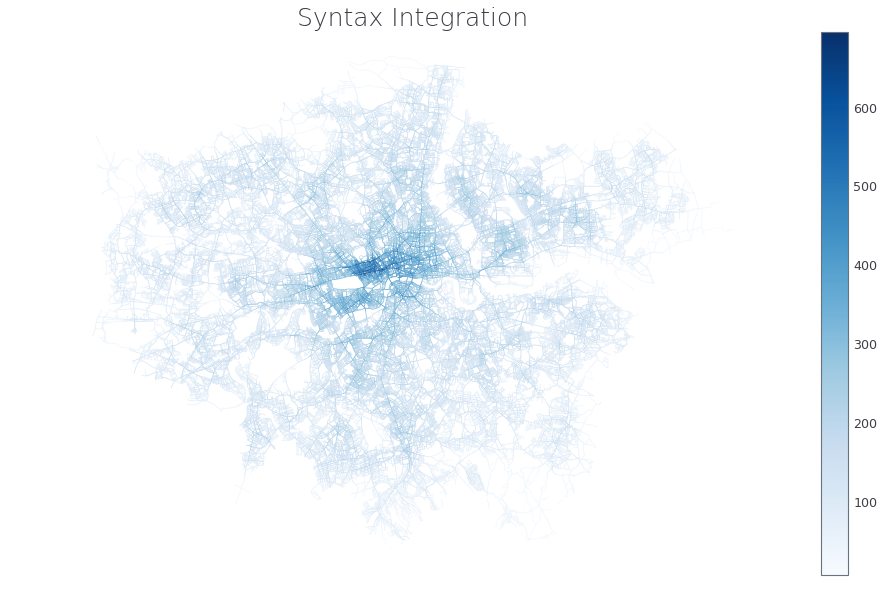

In [67]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
ax.axis('off')
ax.set_title('Syntax Integration', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=syntax_values['INT2K'].min(), vmax=syntax_values['INT2K'].max()))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
syntax_values.plot(ax=ax,column='INT2K', cmap='Blues', linewidth=0.8)

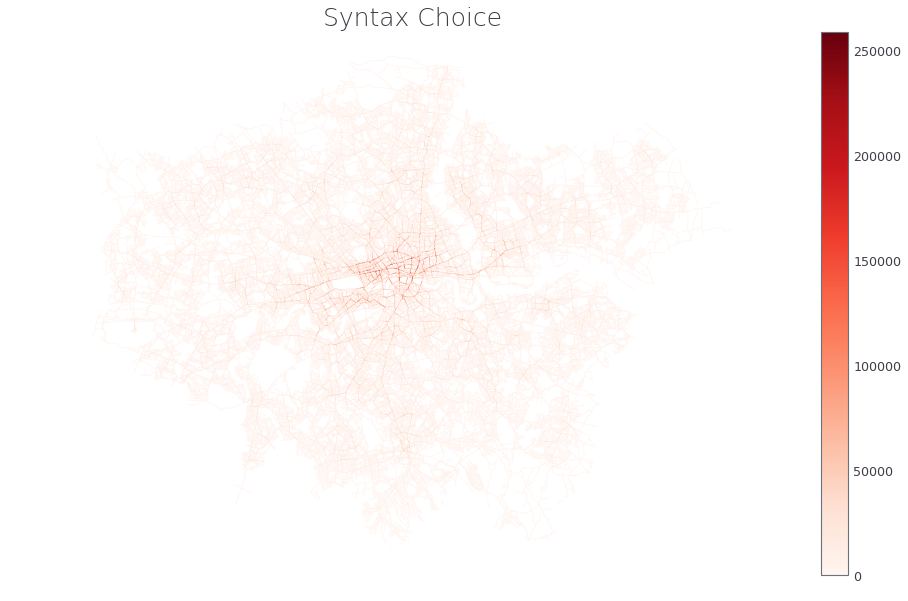

In [69]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
ax.axis('off')
ax.set_title('Syntax Choice', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=syntax_values['CH2K'].min(), vmax=syntax_values['CH2K'].max()))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
syntax_values.plot(ax=ax,column='CH2K', cmap='Reds', linewidth=0.8)

In [70]:
wardLevel_syntax = {'WD15CD':[] , 'Choice' : [] , 'Choice_std' : [] , 'Integration':[] , 'Integration_std':[]}
for name , group in syntax_values.groupby('WD15CD'):
    wardLevel_syntax['WD15CD'].append(name)
    wardLevel_syntax['Choice'].append(np.mean(group['CH2K']))
    wardLevel_syntax['Choice_std'].append(np.std(group['CH2K']))
    wardLevel_syntax['Integration'].append(np.mean(group['INT2K']))
    wardLevel_syntax['Integration_std'].append(np.std(group['INT2K']))
ward_syntax = pd.DataFrame.from_dict(wardLevel_syntax)

In [71]:
import seaborn as sns

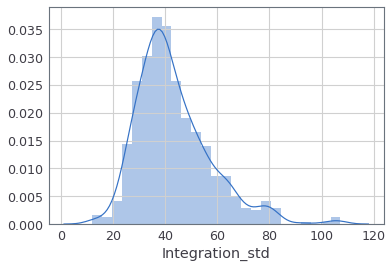

In [76]:
sns.distplot(ward_syntax['Integration_std'])

In [77]:
len(ward_syntax)

634

In [80]:
london_ward_syntax = pd.merge(london_wards, ward_syntax , left_on='GSS_CODE' , right_on='WD15CD')

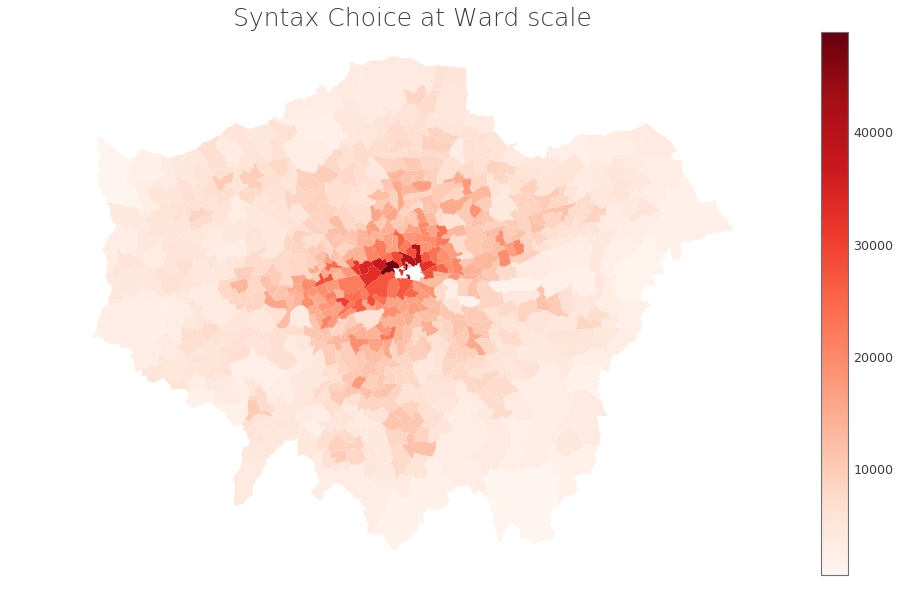

In [85]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
ax.axis('off')
ax.set_title('Syntax Choice at Ward scale', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=london_ward_syntax['Choice'].min(), vmax=london_ward_syntax['Choice'].max()))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
london_ward_syntax.plot(ax=ax,column='Choice', cmap='Reds', linewidth=0.8)

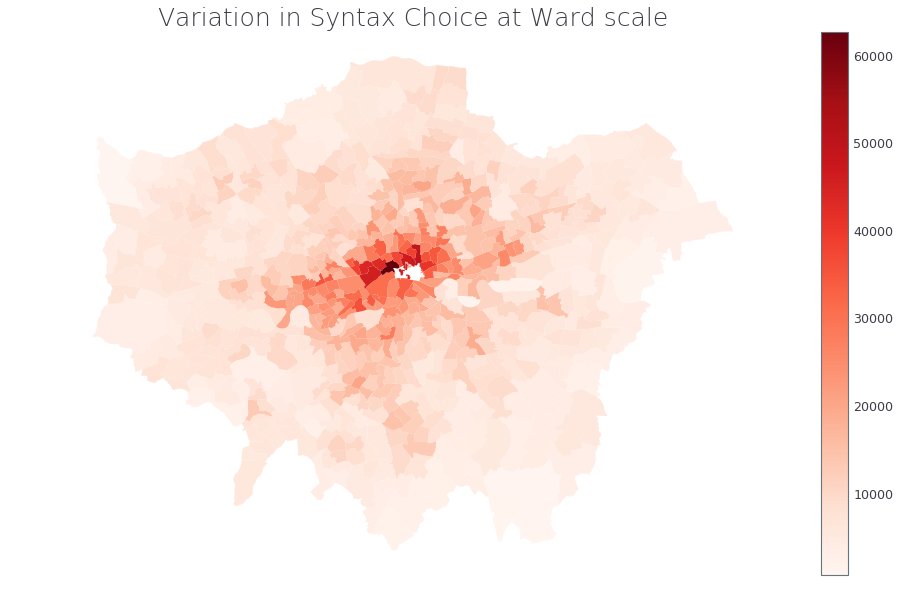

In [83]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
ax.axis('off')
ax.set_title('Variation in Syntax Choice at Ward scale', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=london_ward_syntax['Choice_std'].min(), vmax=london_ward_syntax['Choice_std'].max()))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
london_ward_syntax.plot(ax=ax,column='Choice_std', cmap='Reds', linewidth=0.8)

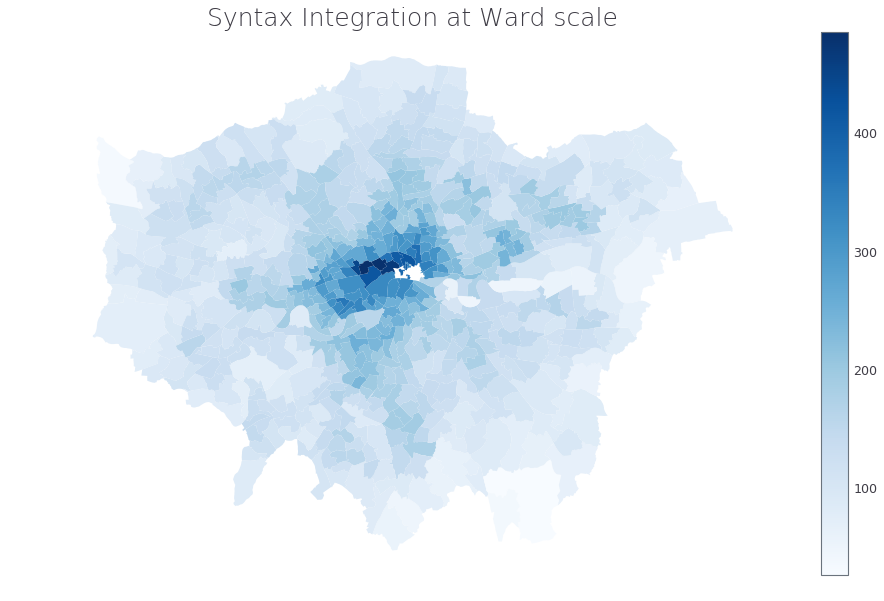

In [84]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
ax.axis('off')
ax.set_title('Syntax Integration at Ward scale', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=london_ward_syntax['Integration'].min(), vmax=london_ward_syntax['Integration'].max()))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
london_ward_syntax.plot(ax=ax,column='Integration', cmap='Blues', linewidth=0.8)

In [86]:
london_ward_syntax.to_csv('London_ward_space_syntax.csv')